In [12]:
from run_sim import run_sim
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os

In [2]:
# set up dataframe for collecting event data
mtd_operation_record, attack_operation_record = run_sim()

Target Node is:  75
Adversary: Start Host Scan at 0.0s.
Adversary: Processed host scan at 5.0s.
Adversary: Start Host Enum at 5.0s.
Adversary: Processed host enum at 10.0s.
Adversary: Start port scan at 10.0s.
Adversary: Processed port scan at 20.0s.
Adversary: Start vulnerability exploitation at 20.0s.
MTD: osdiversity triggered 30.2s
MTD: osdiversity deployed in the network at 30.2s.
Adversary: Processed vulnerabilities exploitation at 50.0s
Adversary: Host 0 has been compromised at 50.0s!: 
Adversary: Start Host Enum at 50.0s.
Adversary: Processed host enum at 55.0s.
Adversary: Start port scan at 55.0s.
MTD: HostTopologyShuffle triggered 60.4s
MTD: HostTopologyShuffle deployed in the network at 60.4s.
MTD: osdiversity finished in 30.5s at 60.6s.
MTD: Interrupted port_scan at 60.6s!
Adversary: Restarting with port scan operation!
Adversary: Start port scan at 62.6s.
Adversary: Processed port scan at 72.6s.
Adversary: Start vulnerability exploitation at 72.6s.
MTD: IPShuffle triggered

In [3]:
mtd_operation_record = pd.DataFrame(mtd_operation_record)
mtd_operation_record

,name,start_time,finish_time,duration
0,osdiversity,30.155736,60.628122,30.472386
1,HostTopologyShuffle,60.356690,100.368808,40.012118
2,UserShuffle,152.111285,162.307192,10.195907
3,IPShuffle,121.646598,171.918540,50.271942
4,UserShuffle,182.228943,192.835217,10.606273
5,UserShuffle,213.596043,224.045705,10.449662
6,serviceDiversity,243.987805,284.335300,40.347495
7,PortShuffle,304.289143,344.648252,40.359109
8,HostTopologyShuffle,334.927394,375.650473,40.723078
9,UserShuffle,366.040516,376.630500,10.589985


In [4]:
# fig1 = go.Figure(go.Waterfall(x = mtd_operation_record['start_time'],
#                               y = mtd_operation_record['name'],
#                               measure = ['absolute']*100,
#                               connector = {"mode":"between", "line":{"color":"red"}}))
#
# fig1.update_layout(title = 'Time duration of MTD operations',
#                    xaxis_title = 'Time' , yaxis_title = 'MTD techniques',
#                    width = 800, height = 600)

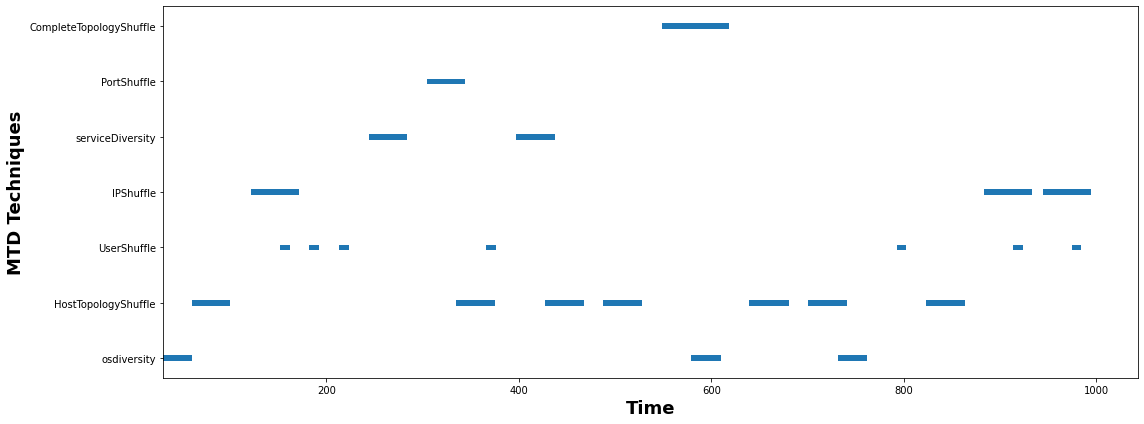

In [5]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.barh(mtd_operation_record['name'], mtd_operation_record['duration'], left=mtd_operation_record['start_time'], height=0.1)

plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('MTD Techniques', weight='bold', fontsize=18)
fig.tight_layout()
plt.show()

In [6]:
attack_operation_record = pd.DataFrame(attack_operation_record)
attack_operation_record

,name,start_time,finish_time,duration,interrupted_in,interrupted_by,current_host,current_host_attempt,current_total_attempt,compromise_host
0,HostScan,0.000000,5.000000,5.000000,,,-1,0,0,
1,HostEnum,5.000000,10.000000,5.000000,,,-1,0,0,
2,PortScan,10.000000,20.000000,10.000000,,,0,1,0,
3,VulnerabilityExploit,20.000000,50.022826,30.022826,,,0,1,0,0
4,HostEnum,50.022826,55.022826,5.000000,,,0,1,9,
...,...,...,...,...,...,...,...,...,...,...
87,HostEnum,940.635061,945.635061,5.000000,,,31,2,180,
88,PortScan,945.635061,955.635061,10.000000,,,26,1,180,
89,VulnerabilityExploit,955.635061,984.624758,28.989697,Network Layer,UserShuffle,26,1,180,
90,HostScan,986.624758,991.624758,5.000000,,,26,1,180,


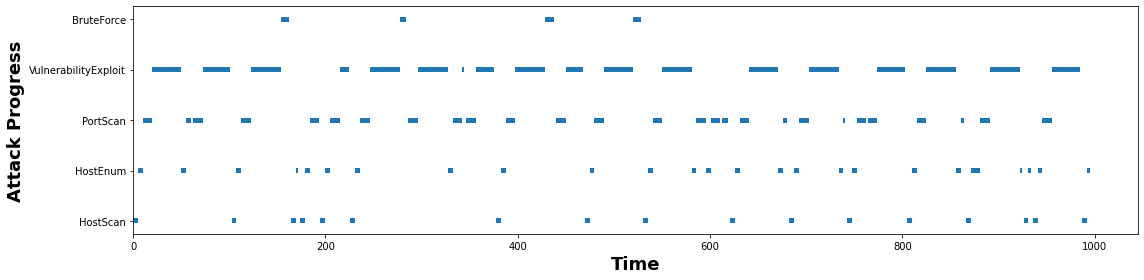

In [7]:
fig2, ax2 = plt.subplots(1, figsize=(16, 4))
ax2.barh(attack_operation_record['name'], attack_operation_record['duration'], left=attack_operation_record['start_time'], height=0.1)

plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('Attack Progress', weight='bold', fontsize=18)
fig2.tight_layout()
plt.show()

In [8]:
attack_operation_record[(attack_operation_record['name'] == 'PortScan') & (attack_operation_record['compromise_host'] != '')]

,name,start_time,finish_time,duration,interrupted_in,interrupted_by,current_host,current_host_attempt,current_total_attempt,compromise_host
51,PortScan,585.896423,595.896423,10.0,,,49,1,71,49


In [9]:
attack_operation_record[(attack_operation_record['name'] == 'VulnerabilityExploit') & (attack_operation_record['compromise_host'] != '')]

,name,start_time,finish_time,duration,interrupted_in,interrupted_by,current_host,current_host_attempt,current_total_attempt,compromise_host
3,VulnerabilityExploit,20.000000,50.022826,30.022826,,,0,1,0,0
28,VulnerabilityExploit,296.335300,327.400818,31.065518,,,40,5,24,40
49,VulnerabilityExploit,550.474680,580.896423,30.421743,,,46,2,56,46
58,VulnerabilityExploit,640.736754,670.755980,30.019226,,,53,1,71,53
64,VulnerabilityExploit,702.435142,733.762328,31.327186,,,38,1,119,38
75,VulnerabilityExploit,824.732094,855.676735,30.944640,,,36,3,155,36
82,VulnerabilityExploit,890.857434,922.358444,31.501010,,,31,2,164,31


In [10]:
attack_operation_record[(attack_operation_record['name'] == 'BruteForce') & (attack_operation_record['compromise_host'] != '')]

,name,start_time,finish_time,duration,interrupted_in,interrupted_by,current_host,current_host_attempt,current_total_attempt,compromise_host


In [20]:
if not os.path.exists('data_analysis'):
    os.makedirs(os.path.dirname('data_analysis'))

attack_operation_record.to_csv('data_analysis/attack_operation_record.csv',index=False)
mtd_operation_record.to_csv('data_analysis/mtd_operation_record.csv', index=False)